In [1]:
""" Transfer Learning: Using Pre-Trained models with an extra Classification layer. We create a model with the layers of pretrained models and
add another layer according to our need.

In this nb, we use a MobileNet model developed by Google. It is trained on ImageNet dataset which has almost 1000 different images. We use this
model to create another model with 2 output classes to classify Cats and Dogs images. """

try:
  %tensorflow_version 2.x
except:
  pass

# Imports
import tensorflow as tf
import tensorflow_hub as hub #PreTrained models are imported from Tensorflow Hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import logging
import PIL.Image as Image
tf.get_logger().setLevel(logging.ERROR)

TensorFlow 2.x selected.


In [0]:
# We first test our imported MobileNet model on a random image 
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL,input_shape = (IMAGE_RES,IMAGE_RES,3))
])

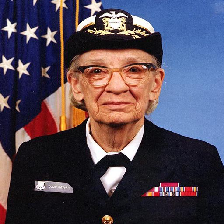

In [3]:
# This is an image which if given to MobileNet, it predicts Military Uniform
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [4]:
grace_hopper = np.array(grace_hopper)/255
grace_hopper.shape

(224, 224, 3)

In [5]:
result = model.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

In [6]:
prediction = np.argmax(result[0],-1)
prediction

653

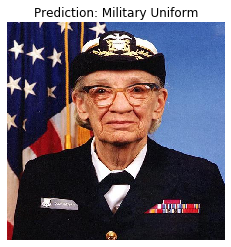

In [7]:
# Plotting image with prediction
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[prediction]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [0]:
# Creating Training and Validation Dataset
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
(train_examples,validation_examples),info = tfds.load('cats_vs_dogs',as_supervised=True,with_info=True,split = splits)
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [9]:
print(num_classes,num_examples)

2 23262


In [0]:
# To resize images
def format_image(image,label):
    image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
    return image,label

batch_size = 32

# Creating batches
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(batch_size).prefetch(1)

In [16]:
# Testing our MobileNet on our dataset
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch, label_batch = image_batch.numpy(), label_batch.numpy()

result_batch = model.predict(image_batch)
predicted_image_batch = imagenet_labels[np.argmax(result_batch, axis = -1)]
predicted_image_batch 
# We can see that the outputs look like breeds of Cats and Dogs

array(['background', 'tench', 'tench', 'tench', 'tench', 'tench',
       'background', 'background', 'tench', 'tench', 'tench', 'tench',
       'background', 'tench', 'background', 'tench', 'tench', 'tench',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background', 'tench',
       'background', 'tench', 'background', 'background', 'background'],
      dtype='<U30')

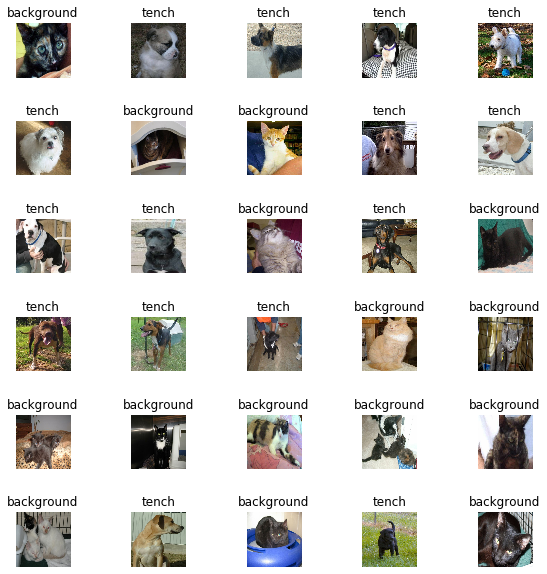

In [17]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.8)
    plt.imshow(image_batch[n])
    plt.title(predicted_image_batch[n])
    plt.axis('off')
# Still, it's not perfect

In [0]:
# Building CatsVSDogs Classifier with MobileNet using Transfer Learning
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,input_shape = (IMAGE_RES,IMAGE_RES,3))
# We don't wanna train the layers of MobileNet model. The parameters of neurons of those layers won't change
feature_extractor.trainable = False

In [24]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data = validation_batches)

Epoch 1/6
582/582 [==============================] - 45s 77ms/step - loss: 0.0529 - accuracy: 0.9823 - val_loss: 0.0318 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 44s 76ms/step - loss: 0.0293 - accuracy: 0.9902 - val_loss: 0.0308 - val_accuracy: 0.9884
Epoch 3/6
582/582 [==============================] - 42s 72ms/step - loss: 0.0253 - accuracy: 0.9914 - val_loss: 0.0330 - val_accuracy: 0.9886
Epoch 4/6
582/582 [==============================] - 42s 71ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0306 - val_accuracy: 0.9888
Epoch 5/6
582/582 [==============================] - 42s 71ms/step - loss: 0.0189 - accuracy: 0.9934 - val_loss: 0.0336 - val_accuracy: 0.9881
Epoch 6/6
582/582 [==============================] - 41s 70ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0339 - val_accuracy: 0.9890


Text(0.5, 1.0, 'Loss Graphs')

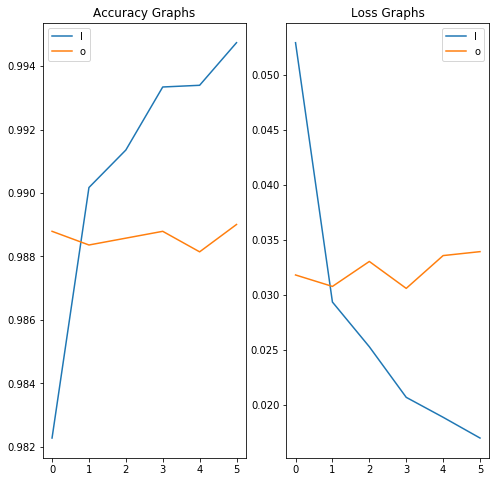

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.title('Accuracy Graphs')
plt.legend('lower right')
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend('lower right')
plt.title('Loss Graphs')

In [0]:
class_names = np.array(info.features['label'].names)
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]

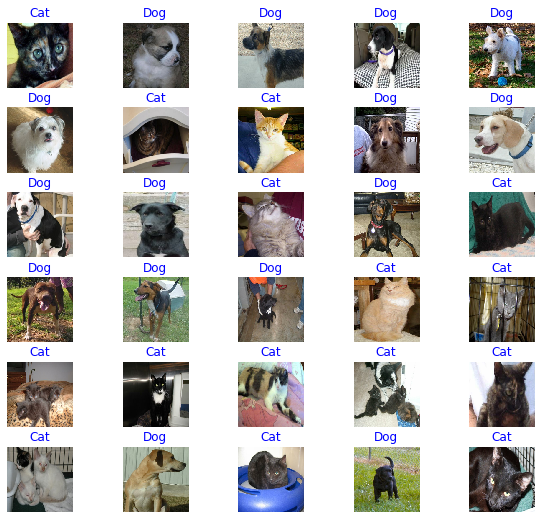

In [28]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
    plt.title(predicted_class_names[n].title(), color = color)
    plt.axis('off')